Clusters: 2, DB Index: 1.605, Silhouette: 0.224
Clusters: 3, DB Index: 1.560, Silhouette: 0.197
Clusters: 4, DB Index: 1.486, Silhouette: 0.191
Clusters: 5, DB Index: 1.411, Silhouette: 0.204
Clusters: 6, DB Index: 1.396, Silhouette: 0.204
Clusters: 7, DB Index: 1.291, Silhouette: 0.204
Clusters: 8, DB Index: 1.413, Silhouette: 0.193
Clusters: 9, DB Index: 1.332, Silhouette: 0.196
Clusters: 10, DB Index: 1.286, Silhouette: 0.200
Optimal number of clusters: 10


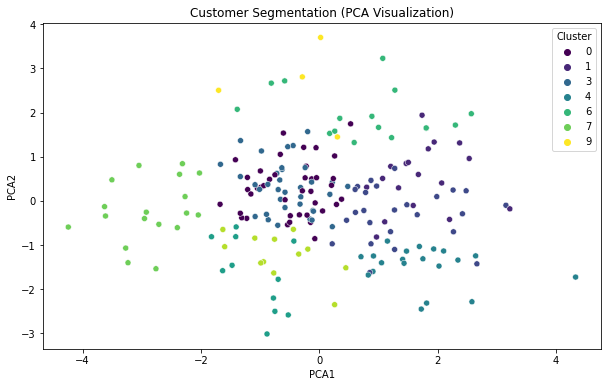

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

transaction_agg = transactions.groupby('CustomerID').agg({'TotalValue': ['sum', 'mean', 'count'],  # Spend, avg spend, frequency
    'Quantity': ['mean']  # Avg quantity per transaction
}).reset_index()
transaction_agg.columns = [
    'CustomerID', 'TotalSpend', 'AvgTransactionValue', 'TransactionCount', 'AvgQuantity'
]

customers['SignupDays'] = (pd.to_datetime('today') - pd.to_datetime(customers['SignupDate'])).dt.days
customers = customers.drop(columns=['SignupDate'])

# Merge datasets
data = pd.merge(customers, transaction_agg, on='CustomerID', how='inner')

# Preprocessing
numeric_features = ['TotalSpend', 'AvgTransactionValue', 'TransactionCount', 'AvgQuantity', 'SignupDays']
categorical_features = ['Region']

scaler = StandardScaler()
data[numeric_features] = scaler.fit_transform(data[numeric_features])

encoder = OneHotEncoder(sparse=False, drop='first')
encoded_region = encoder.fit_transform(data[['Region']])
encoded_region_df = pd.DataFrame(encoded_region, columns=encoder.get_feature_names_out(['Region']))
data = pd.concat([data, encoded_region_df], axis=1).drop(columns=['Region'])

# Clustering
db_scores = []
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(data.drop(columns=['CustomerID', 'CustomerName']))
    db_index = davies_bouldin_score(data.drop(columns=['CustomerID', 'CustomerName']), clusters)
    silhouette_avg = silhouette_score(data.drop(columns=['CustomerID', 'CustomerName']), clusters)
    db_scores.append((k, db_index))
    silhouette_scores.append((k, silhouette_avg))
    print(f"Clusters: {k}, DB Index: {db_index:.3f}, Silhouette: {silhouette_avg:.3f}")

# Optimal clusters
optimal_k = min(db_scores, key=lambda x: x[1])[0]
print(f"Optimal number of clusters: {optimal_k}")

# Final clustering
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['Cluster'] = final_kmeans.fit_predict(data.drop(columns=['CustomerID', 'CustomerName']))

# Visualization
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data.drop(columns=['CustomerID', 'CustomerName', 'Cluster']))
data['PCA1'], data['PCA2'] = pca_data[:, 0], pca_data[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='PCA1', y='PCA2', hue='Cluster', palette='viridis')
plt.title('Customer Segmentation (PCA Visualization)')
plt.show()
